In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

In [ ]:
df = pd.read_csv('price.csv')

In [ ]:
df.rename(columns={'Стоимость доставки (тенге)': 'price'}, inplace=True)

In [ ]:
# FILL MISSING VALUES IN TARGET
median_price = df['price'].median()
df['price'].fillna(median_price, inplace=True)

<ipython-input-18-b10add22e3d7>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(median_price, inplace=True)


In [ ]:
# SPLIT FEATURES / TARGET
X = df.drop(columns=['price'])
y = df['price']


In [ ]:
# IDENTIFY NUMERIC vs CATEGORICAL FEATURES
numeric_features   = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['Расстояние (км)', 'Вес груза (кг)', 'Объём груза (м³)', 'Плотность (кг/м³)', 'Стоимость топлива (тенге/л)', 'Зарплата водителя (тенге)', 'Налоги и сборы (тенге)']
Categorical features: ['Тип груза', 'Тип транспорта']


In [ ]:
desc = X[numeric_features].describe().T[['min','max','mean','std']]
print("\nNumeric feature ranges:\n", desc)


Numeric feature ranges:
                                        min       max           mean  \
Расстояние (км)                  81.000000    3132.0    1529.434611   
Вес груза (кг)                  300.000000   39959.0   11374.450022   
Объём груза (м³)                  0.449982     122.9      29.685607   
Плотность (кг/м³)                70.000000    2499.0     496.630826   
Стоимость топлива (тенге/л)     180.000000     260.0     219.889820   
Зарплата водителя (тенге)    100011.000000  199994.0  149796.763703   
Налоги и сборы (тенге)        15082.000000   49634.0   29964.846078   

                                      std  
Расстояние (км)                835.380130  
Вес груза (кг)               10203.623665  
Объём груза (м³)                24.041215  
Плотность (кг/м³)              456.085396  
Стоимость топлива (тенге/л)     23.048223  
Зарплата водителя (тенге)    28918.982892  
Налоги и сборы (тенге)        7268.786182  


In [ ]:
# BUILD PREPROCESSOR
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer',    SimpleImputer(strategy='most_frequent')),
    ('onehot',     OneHotEncoder(handle_unknown='ignore', sparse_output=False)), # Changed 'sparse' to 'sparse_output'
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

In [ ]:
# SPLIT TRAIN / TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# DEFINE MODEL PIPELINES
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
# TRAIN
print("\nTraining Random Forest…")
rf_pipeline.fit(X_train, y_train)

print("Training XGBoost…")
xgb_pipeline.fit(X_train, y_train)


Training Random Forest…
Training XGBoost…


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Расстояние (км)',
                                                   'Вес груза (кг)',
                                                   'Объём груза (м³)',
                                                   'Плотность (кг/м³)',
                                                   'Стоимость топлива '
                                                   '(тенге/л)',
                                                   'Зарплата водителя (тенге)',
                                                   'Налоги и сборы (тенге)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_freq...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# EVALUATE
print("\nEvaluating on test set:")
for name, model in [('Random Forest', rf_pipeline), ('XGBoost', xgb_pipeline)]:
    preds = model.predict(X_test)
    # Calculate RMSE without the 'squared' argument, then take the square root
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    print(f"  {name:<13} RMSE = {rmse:,.2f} ₸   |   R² = {r2:.4f}")


Evaluating on test set:
  Random Forest RMSE = 18,251.82 ₸   |   R² = 0.9371
  XGBoost       RMSE = 17,411.22 ₸   |   R² = 0.9427


<ipython-input-32-de6a781ddd20>:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plt.plot(y_test.ravel(), label="Actual", alpha=0.7)


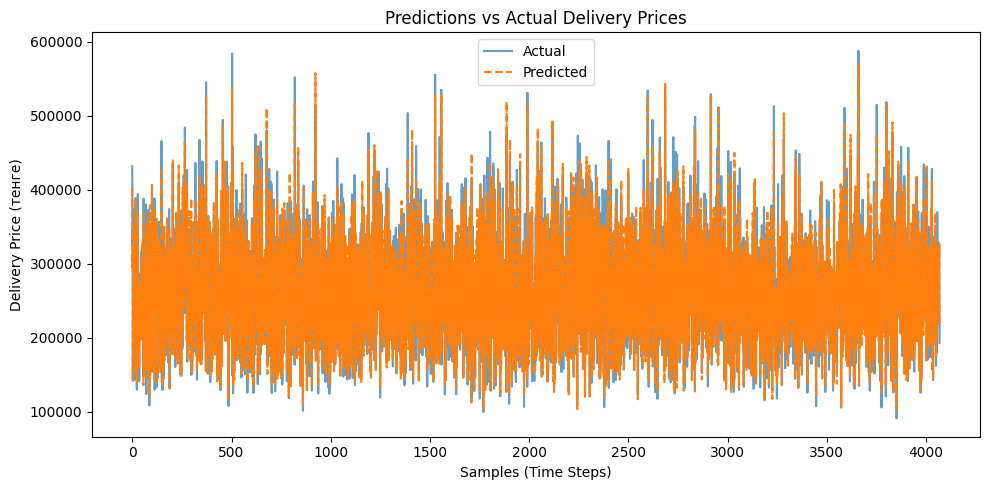

In [32]:
import matplotlib.pyplot as plt
# Predict with Random Forest model
y_pred = rf_pipeline.predict(X_test)

# Plot predictions vs actual values
plt.figure(figsize=(10,5))
plt.plot(y_test.ravel(), label="Actual", alpha=0.7)
plt.plot(y_pred.ravel(), label="Predicted", linestyle='dashed')
plt.title("Predictions vs Actual Delivery Prices")
plt.xlabel("Samples (Time Steps)")
plt.ylabel("Delivery Price (тенге)")
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-34-a438b71e2c0a>:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plt.plot(y_test.ravel(), label="Actual", alpha=0.7)


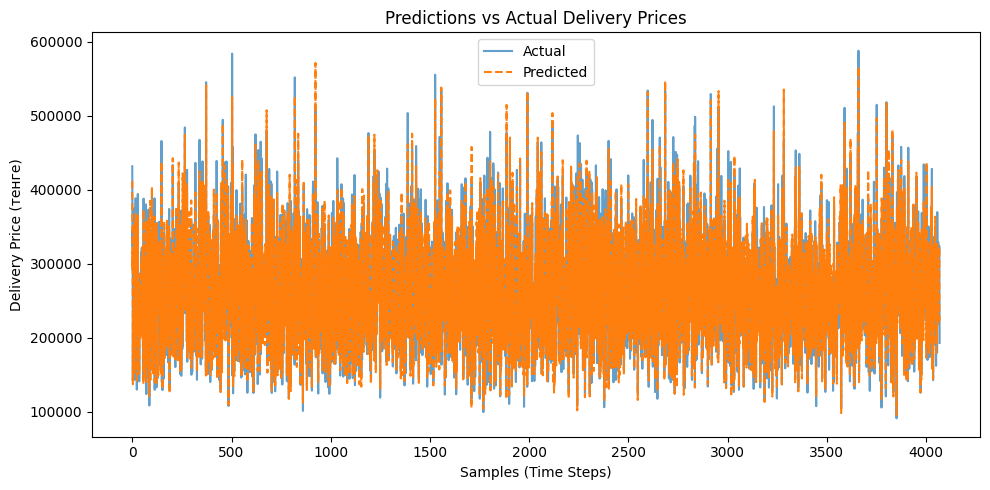

In [34]:

y_pred_2= xgb_pipeline.predict(X_test)

# Plot predictions vs actual values
plt.figure(figsize=(10,5))
plt.plot(y_test.ravel(), label="Actual", alpha=0.7)
plt.plot(y_pred_2.ravel(), label="Predicted", linestyle='dashed')
plt.title("Predictions vs Actual Delivery Prices")
plt.xlabel("Samples (Time Steps)")
plt.ylabel("Delivery Price (тенге)")
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Impute NaNs before scaling
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

preprocessor_mlp = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])


mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor_mlp),  # Include the preprocessor in the pipeline
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128,64,32),
        activation='relu',
        solver='adam',
        max_iter=200,
        random_state=42
    ))
])

mlp_pipeline.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Расстояние (км)',
                                                   'Вес груза (кг)',
                                                   'Объём груза (м³)',
                                                   'Плотность (кг/м³)',
                                                   'Стоимость топлива '
                                                   '(тенге/л)',
                                                   'Зарплата водителя (тенге)',
                                                   'Налоги и сборы (тенге)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип груза',
                                                   'Тип транспорта'])])),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(128, 64, 32),
                              random_state=42))])

In [47]:
y_pred_mlp = mlp_pipeline.predict(X_test)

# Calculate RMSE by taking the square root of MSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp))

print("MLP       RMSE = {:.2f} ₸   |   R² = {:.4f}"
      .format(rmse, r2_score(y_test, y_pred_mlp)))

MLP       RMSE = 18004.72 ₸   |   R² = 0.9387


In [41]:
!pip install -q catboost

from catboost import CatBoostRegressor




In [42]:
# get indices of categorical columns
cat_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# Convert categorical columns to string type before fitting
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

cat_model = CatBoostRegressor(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)

In [43]:
cat_model.fit(
    X_train, y_train,
    cat_features=cat_indices,
    eval_set=(X_test, y_test),
    verbose=False
)

In [45]:
y_pred_cat = cat_model.predict(X_test)
# Calculate RMSE without the 'squared' argument, then take the square root
rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))
r2 = r2_score(y_test, y_pred_cat)
print("CatBoost  RMSE = {:.2f} ₸   |   R² = {:.4f}"
      .format(rmse, r2))

CatBoost  RMSE = 16233.79 ₸   |   R² = 0.9502


In [49]:
# ─────────────────────────────────────────────────────────────────────────────
# PREPROCESS & SCALE FOR DL MODELS

from sklearn.preprocessing import StandardScaler

# 1) transform
X_train_enc = preprocessor.transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

# 2) scale everything to zero mean, unit variance
scaler_dl = StandardScaler()
X_train_dl = scaler_dl.fit_transform(X_train_enc)
X_test_dl  = scaler_dl.transform(X_test_enc)

# reshape for models that expect a "sequence" dimension
import numpy as np
n_feat = X_train_dl.shape[1]
X_train_seq = X_train_dl.reshape(-1, n_feat, 1)
X_test_seq  = X_test_dl.reshape(-1, n_feat, 1)

In [50]:
# 1D CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout

cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_feat,1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
cnn.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_cnn = cnn.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=50, batch_size=256, verbose=2
)


Epoch 1/50
64/64 - 6s - 100ms/step - loss: 75251687424.0000 - root_mean_squared_error: 274320.4062 - val_loss: 74396786688.0000 - val_root_mean_squared_error: 272757.7500
Epoch 2/50
64/64 - 2s - 25ms/step - loss: 75089797120.0000 - root_mean_squared_error: 274025.1875 - val_loss: 73945014272.0000 - val_root_mean_squared_error: 271928.3125
Epoch 3/50
64/64 - 3s - 44ms/step - loss: 73802121216.0000 - root_mean_squared_error: 271665.4688 - val_loss: 71330349056.0000 - val_root_mean_squared_error: 267077.4062
Epoch 4/50
64/64 - 2s - 26ms/step - loss: 68710289408.0000 - root_mean_squared_error: 262126.4688 - val_loss: 62977892352.0000 - val_root_mean_squared_error: 250953.9688
Epoch 5/50
64/64 - 1s - 19ms/step - loss: 56060252160.0000 - root_mean_squared_error: 236770.4688 - val_loss: 45776662528.0000 - val_root_mean_squared_error: 213954.8125
Epoch 6/50
64/64 - 1s - 17ms/step - loss: 35724681216.0000 - root_mean_squared_error: 189009.7344 - val_loss: 23897843712.0000 - val_root_mean_square

In [53]:
# Evaluate the 1D CNN model
cnn_loss, cnn_rmse = cnn.evaluate(X_test_seq, y_test, verbose=0)

print(f"1D CNN - Loss: {cnn_loss:.4f}, RMSE: {cnn_rmse:.2f} ₸")

from sklearn.metrics import mean_absolute_error, r2_score

y_pred_cnn = cnn.predict(X_test_seq)
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
r2_cnn = r2_score(y_test, y_pred_cnn)

print(f"1D CNN - MAE: {mae_cnn:.2f} ₸, R-squared: {r2_cnn:.4f}")


1D CNN - Loss: 4482459136.0000, RMSE: 66951.17 ₸
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1D CNN - MAE: 54067.58 ₸, R-squared: 0.1530


In [54]:
# LSTM Model
from tensorflow.keras.layers import LSTM

lstm = Sequential([
    LSTM(64, input_shape=(n_feat,1), return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
lstm.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_lstm = lstm.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    epochs=50, batch_size=256, verbose=2
)

Epoch 1/50
64/64 - 8s - 120ms/step - loss: 75250008064.0000 - root_mean_squared_error: 274317.3438 - val_loss: 74398040064.0000 - val_root_mean_squared_error: 272760.0312
Epoch 2/50
64/64 - 2s - 33ms/step - loss: 75208089600.0000 - root_mean_squared_error: 274240.9375 - val_loss: 74344685568.0000 - val_root_mean_squared_error: 272662.2188
Epoch 3/50
64/64 - 2s - 29ms/step - loss: 75142135808.0000 - root_mean_squared_error: 274120.6562 - val_loss: 74265739264.0000 - val_root_mean_squared_error: 272517.4062
Epoch 4/50
64/64 - 2s - 36ms/step - loss: 75049435136.0000 - root_mean_squared_error: 273951.5312 - val_loss: 74159816704.0000 - val_root_mean_squared_error: 272323.0000
Epoch 5/50
64/64 - 3s - 44ms/step - loss: 74929512448.0000 - root_mean_squared_error: 273732.5625 - val_loss: 74026754048.0000 - val_root_mean_squared_error: 272078.5938
Epoch 6/50
64/64 - 5s - 83ms/step - loss: 74782318592.0000 - root_mean_squared_error: 273463.5625 - val_loss: 73866362880.0000 - val_root_mean_square

In [56]:
# prompt: evaluation metrics for LSTM

# Evaluate the LSTM model
lstm_loss, lstm_rmse = lstm.evaluate(X_test_seq, y_test, verbose=0)

print(f"LSTM - Loss: {lstm_loss:.4f}, RMSE: {lstm_rmse:.2f} ₸")

y_pred_lstm = lstm.predict(X_test_seq)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM - MAE: {mae_lstm:.2f} ₸, R-squared: {r2_lstm:.4f}")


LSTM - Loss: 49790881792.0000, RMSE: 223138.70 ₸
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM - MAE: 210947.39 ₸, R-squared: -8.4086


In [57]:
import joblib

# Save the models
joblib.dump(rf_pipeline, 'rf_model.pkl')
joblib.dump(xgb_pipeline, 'xgb_model.pkl')
joblib.dump(mlp_pipeline, 'mlp_model.pkl')
joblib.dump(cat_model, 'cat_model.pkl')
cnn.save('cnn_model.h5')
lstm.save('lstm_model.h5')


# Download the models
from google.colab import files
files.download('rf_model.pkl')
files.download('xgb_model.pkl')
files.download('mlp_model.pkl')
files.download('cat_model.pkl')
files.download('cnn_model.h5')
files.download('lstm_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>